In [7]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

# Replace 'path/to/merged_TimeWVHT_data.csv' with the actual path to your CSV file
df = pd.read_csv('merged_TimeWVHT_data.csv')

# Preview the first few rows
print(df.head())

# Print general data information (like column names, data types, and non-null counts)
print("\nDataFrame Info:")
print(df.info())

# Print descriptive statistics for each numerical column
print("\nDataFrame Statistics:")
print(df.describe())

      #YY   MM   DD       ATMP       WTMP      WVHT
0  2020.0  1.0  1.0  26.772222  28.212500  1.245833
1  2020.0  1.0  2.0  27.189928  28.054167  1.108333
2  2020.0  1.0  3.0  26.284722  27.933333  1.212500
3  2020.0  1.0  4.0  26.873611  27.754167  1.291667
4  2020.0  1.0  5.0  25.072222  27.808333  1.233333

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   #YY     1453 non-null   float64
 1   MM      1453 non-null   float64
 2   DD      1453 non-null   float64
 3   ATMP    1453 non-null   float64
 4   WTMP    1453 non-null   float64
 5   WVHT    1453 non-null   float64
dtypes: float64(6)
memory usage: 68.2 KB
None

DataFrame Statistics:
               #YY           MM           DD         ATMP         WTMP  \
count  1453.000000  1453.000000  1453.000000  1453.000000  1453.000000   
mean   2021.499656     6.531315    15.689608    27.0

In [5]:
# Ensure the columns are integers (if they're strings, convert them)
df['Year'] = df['#YY'].astype(int)
df['Month'] = df['MM'].astype(int)
df['Day'] = df['DD'].astype(int)

# Combine Year, Month, Day into a single datetime column
df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Method 1: Using apply and timestamp() (this returns a float)
df['unix_time'] = df['datetime'].apply(lambda x: x.timestamp())

# Alternatively, Method 2: Vectorized approach
# This retrieves nanoseconds since epoch, then convert to seconds
df['unix_time'] = (df['datetime'].view('int64') // 10**9)

# View the first few rows to verify the transformation
print(df.head())

      #YY   MM   DD       ATMP       WTMP      WVHT  Year  Month  Day  \
0  2020.0  1.0  1.0  26.772222  28.212500  1.245833  2020      1    1   
1  2020.0  1.0  2.0  27.189928  28.054167  1.108333  2020      1    2   
2  2020.0  1.0  3.0  26.284722  27.933333  1.212500  2020      1    3   
3  2020.0  1.0  4.0  26.873611  27.754167  1.291667  2020      1    4   
4  2020.0  1.0  5.0  25.072222  27.808333  1.233333  2020      1    5   

    datetime   unix_time  
0 2020-01-01  1577836800  
1 2020-01-02  1577923200  
2 2020-01-03  1578009600  
3 2020-01-04  1578096000  
4 2020-01-05  1578182400  


/var/folders/jn/s0h_8_f96h3cr21q3p6wmlbm0000gn/T/ipykernel_17066/3156689699.py:14: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['unix_time'] = (df['datetime'].view('int64') // 10**9)


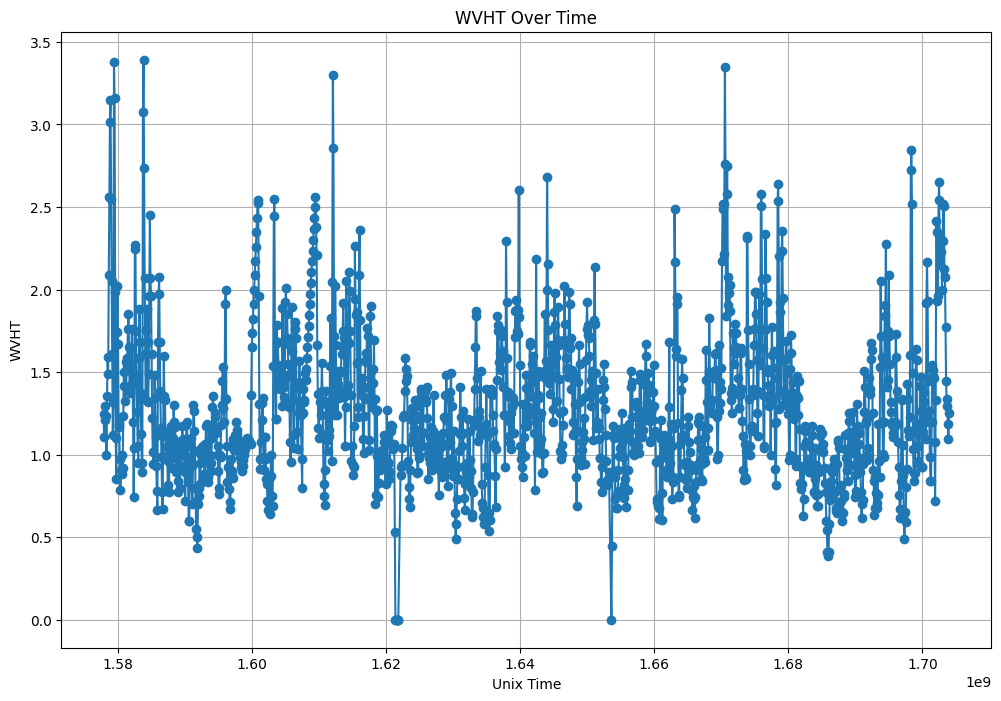

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(df['unix_time'], df['WVHT'], marker='o', linestyle='-')  # marker and linestyle are optional
plt.xlabel('Unix Time')
plt.ylabel('WVHT')
plt.title('WVHT Over Time')
plt.grid(True)
plt.show()

21:28:34 - cmdstanpy - INFO - Chain [1] start processing
21:28:34 - cmdstanpy - INFO - Chain [1] done processing


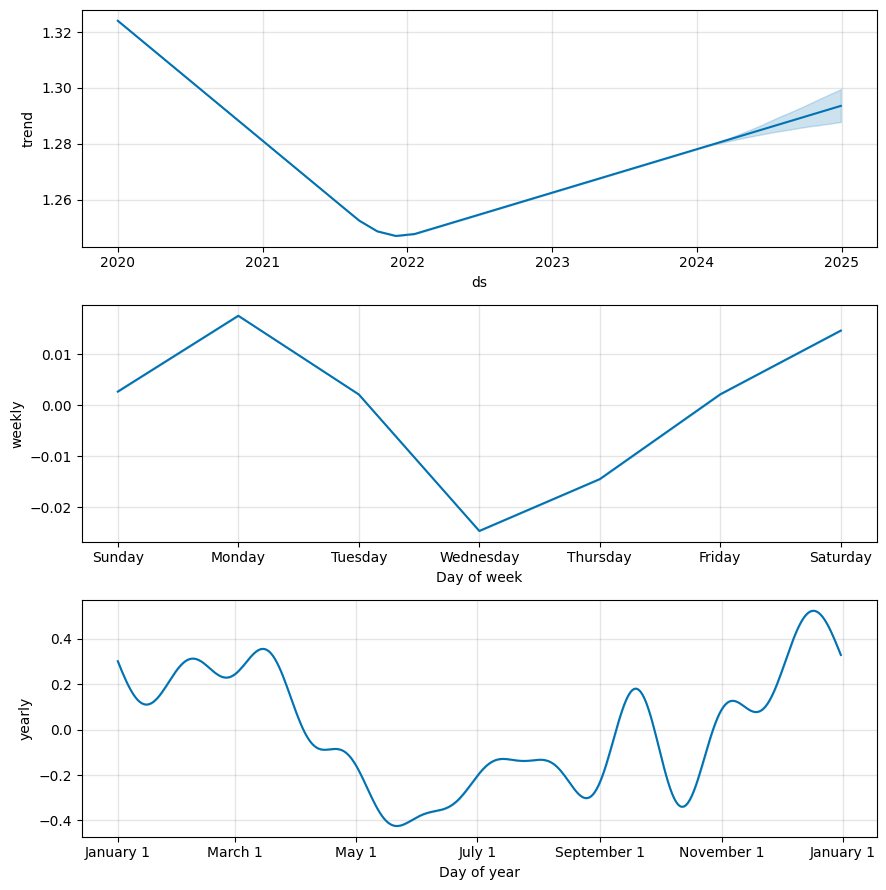

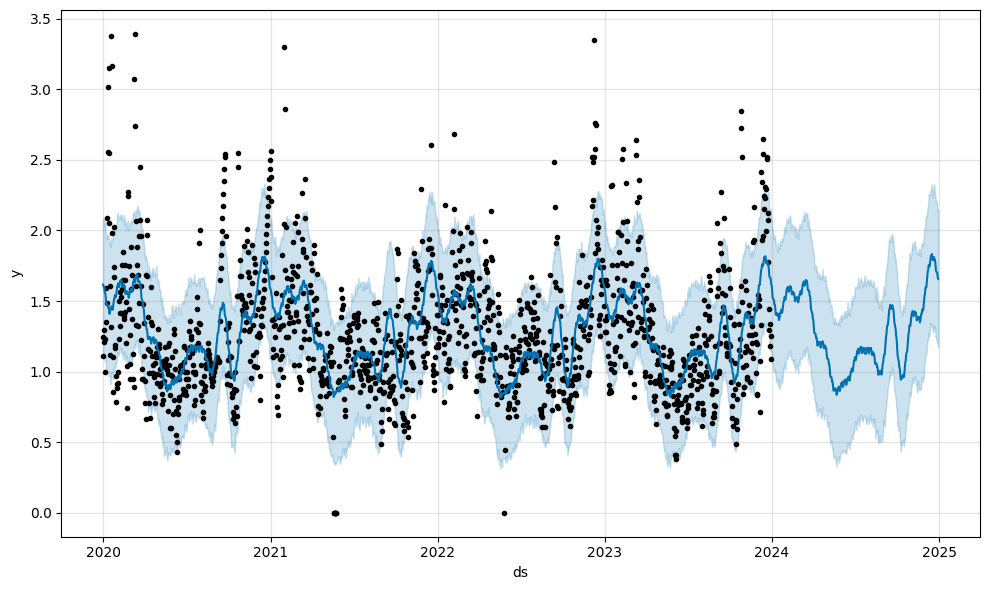

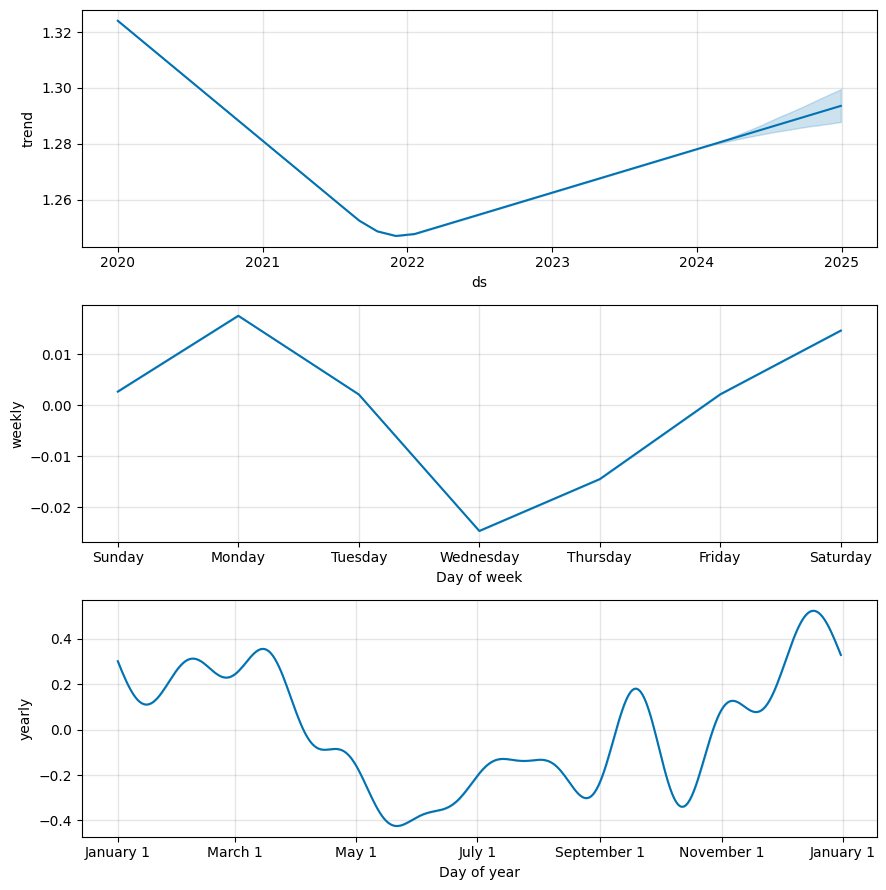

In [18]:
import pandas as pd
from prophet import Prophet

# Assuming df has 'datetime' and 'WVHT'
# Ensure 'datetime' is a datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Rename columns to Prophet's expected format
df_prophet = df.rename(columns={'datetime': 'ds', 'WVHT': 'y'})

# By default Prophet models yearly seasonality. If you want to ensure it:
model = Prophet(yearly_seasonality=True)  
model.fit(df_prophet)

future = model.make_future_dataframe(periods=365)  # daily frequency by default
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)

# Plot the components: trend, yearly seasonality
model.plot_components(forecast)

22:23:37 - cmdstanpy - INFO - Chain [1] start processing
22:23:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error on 2024 Test Data: 0.27986074640256087


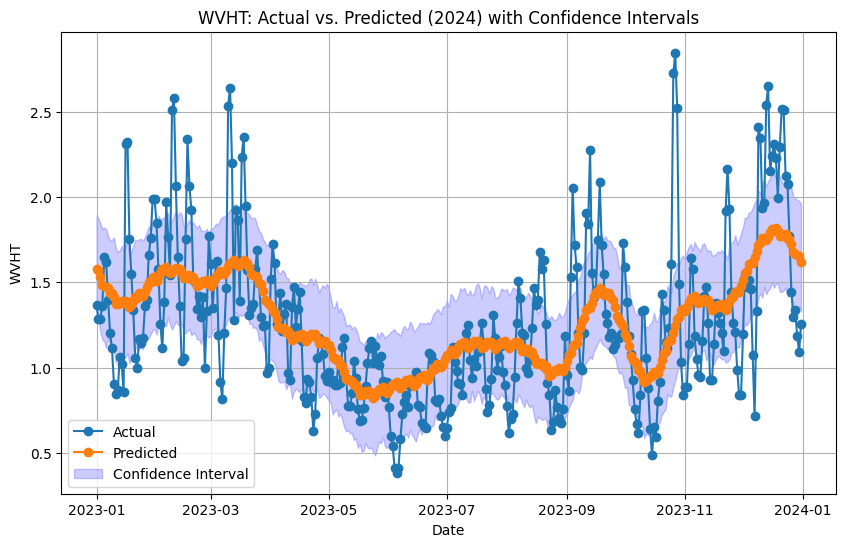

Forecast saved to forecast.csv


In [26]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Ensure datetime is in correct format
df['datetime'] = pd.to_datetime(df['datetime'])

# Rename columns for Prophet
df_prophet = df.rename(columns={'datetime': 'ds', 'WVHT': 'y'})

# Split the data into train (2020-2023) and test (2024)
train_df = df_prophet[df_prophet['ds'] < '2024-01-01']
test_df = df_prophet[df_prophet['ds'] >= '2023-01-01']

# Train the Prophet model on the training set only
model = Prophet(yearly_seasonality=True, interval_width=0.60)
model.fit(train_df)

# Determine how long to forecast into the future: 
last_train_date = train_df['ds'].max()
last_test_date = test_df['ds'].max()
periods = (last_test_date - last_train_date).days

future = model.make_future_dataframe(periods=periods)
forecast = model.predict(future)

# Extract only forecasts for the test period
forecast_test = forecast[forecast['ds'] >= '2023-01-01'].copy()

# Merge actual and predicted
test_merged = pd.merge(test_df[['ds','y']], 
                       forecast_test[['ds','yhat', 'yhat_lower', 'yhat_upper']], 
                       on='ds', how='inner')

# Compute accuracy (MAE)
mae = mean_absolute_error(test_merged['y'], test_merged['yhat'])
print("Mean Absolute Error on 2024 Test Data:", mae)

# Plot actual vs predicted with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(test_merged['ds'], test_merged['y'], label='Actual', marker='o')
plt.plot(test_merged['ds'], test_merged['yhat'], label='Predicted', marker='o')

# Add confidence interval as a shaded region
plt.fill_between(test_merged['ds'], 
                 test_merged['yhat_lower'], 
                 test_merged['yhat_upper'], 
                 color='blue', alpha=0.2, label='Confidence Interval')

plt.title('WVHT: Actual vs. Predicted (2024) with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('WVHT')
plt.grid(True)
plt.legend()
plt.show()

station_id = "station_42042"  # Replace with the appropriate station ID
forecast_test['station_id'] = station_id

# Select only the required columns
output_df = forecast_test[['station_id', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Save to CSV
output_df.to_csv('forecast.csv', index=False)

print("Forecast saved to forecast.csv")

In [16]:
print("Train shape:", train_df.shape)
print("Train dates:", train_df['ds'].min(), "to", train_df['ds'].max())
print("Test shape:", test_df.shape)
print("Test dates:", test_df['ds'].min() if not test_df.empty else "No test data",
      "to", test_df['ds'].max() if not test_df.empty else "No test data")

Train shape: (1453, 11)
Train dates: 2020-01-01 00:00:00 to 2023-12-31 00:00:00
Test shape: (0, 11)
Test dates: No test data to No test data
